# Rapamycin Treatment Model
Now that we have a fully identifiable model of the *in vitro* erythroid differentiation, let's use it to study the effect of rapamycin on the differentiation process. In this notebook, we start be defining a function which computes the likelihood of a model where some parameters are fixed to a reference value. Then we compute the parameter values for the 64 possible models of rapamycin treatment. We show the distribution of parameter variations for these 64 models and then we select the best model of rapamycin treatment. We show the parameter variations in this model, and we finish by simulating it.

In [1]:
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme

def update_theme(change):
    """ display chosen theme from dropdown menu """
    name = change['new']
    html_css = set_nb_theme(name)
    display(html_css)

themes = get_themes()
print(themes)
set_nb_theme(themes[2])

['chesterish', 'grade3', 'oceans16', 'onedork']


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import rc
%matplotlib inline

rc('text', usetex=False)
rc('font', **{'family': 'sans-serif', 'sans-serif':'DejaVu Sans'})
rc('mathtext', **{'fontset': 'custom', 'rm':'DejaVu Sans', 'it':'DejaVu Sans:italic', 'bf':'DejaVu Sans:bold'})

In [3]:
from imp import reload
import numpy as np
from itertools import combinations
import SCB_estimate as SCBe
import Error_Model as EM
import Custom_Estimation_Routines as CER
import Profile_Likelihood as PL
import Selection_Criteria as SC
reload(CER)

data = '../data/Cell_counts_DMSO.csv'  #path to dataset
duration = 5                           #how many timepoints should we consider in the estimation

DMSO_data = np.genfromtxt(data)
DMSO_data = DMSO_data[:,:duration]
t=np.arange(duration)
Rapa_data = np.genfromtxt('../data/Cell_counts_Rapa.csv')
Rapa_data = Rapa_data[:,:duration]
t=np.arange(duration)

Params_DMSO = np.loadtxt('../data/02_Error_Model_Selection/Proportional_Error_%id.params'%(duration-1))
rhoS,deltaSC,b1,rhoC,deltaCB,rhoB,b2=Params_DMSO
Params1_DMSO= np.array([rhoS,b1])
Params2_DMSO= Params_DMSO[3:]
Params_DMSO = np.array([rhoS,b1,rhoC,deltaCB,rhoB,b2])

Bounds=[(None,None),(0,None),(None,None),(0,None),(None,None),(0,None)]

## Generalizing Profile Likelihood Estimation

In [4]:
def GPL_estimation(varying_parameters,Data,Reference_parameters,References_likelihoods,Bounds,verbose_success=True,verbose_error=False):
    """Computes a generalized version of profile likelihood, where any number of parameters are allowed to vary"""
    
    Params1_DMSO=Reference_parameters[:2]  #Reference parameter values for the first estimation step
    Params2_DMSO=Reference_parameters[2:]  #Reference parameter values for the second estimation step
    
    n1=np.sum(varying_parameters<2)  #number of varying parameters in the first step
    n2=np.sum(varying_parameters>=2) #number of varying parameters in the second step

    #now we build the list of parameters that won't change...
    c1=list(range(2))  #... in the first estimation step...
    c2=list(range(4))  #... and in the second one.
    B1=[]              #Bounds for the first estimation step
    B2=[]              #Bounds for the second estimation step
    for i in varying_parameters:
        if i in c1:
            c1.remove(i)
            B1+=[Bounds[i]]
        if i-2 in c2:
            c2.remove(i-2)
            B2+=[Bounds[i]]
    
    #Optimization parameters:
    nruns1=100 #number of independent runs of the first optimization step
    nruns2=500 #number of independent runs of the second optimization step
    LHS=False #should we perform LHS on initial guesses (apparently, it's not working very well with proportional error)
    maxiter=int(1e6)  #maximum duration (in evaluations of the model) of one run
    
    #Going to the details of the estimation:
    if n1>0:  #First estimation step
        d1=c1  #positions at which to insert the constant parameters
        if verbose_success or verbose_error:
            print(n1)
            print(c1)
            print(d1)
    
        opt1=CER.Sample_Estimate(PL.profile_likelihood,
                                 n1,
                                 (d1,Params1_DMSO[c1],EM.logLikelihood_ProportionalError,(Data[0],SCBe.S,t,Data[0,0])),
                                 nsamples=nruns1,
                                 lhs=LHS,
                                 maxeval=maxiter,
                                 bounds=B1,
                                 full_output=True,
                                 verbose_success=verbose_success,
                                 verbose_error=verbose_error)
        params1=np.insert(opt1['parameters'],d1,Params1_DMSO[c1])
        l1=opt1['error']
    else:
        params1=Params1_DMSO
        l1=References_likelihoods[0]
    deltaSC_tmp=params1[0]+0.5*np.log(Data[0,0])  #the relationship between RhoS and DeltaSc is unaffected by the drug treatments.
    other_params=np.array([params1[0],deltaSC_tmp])

    if n2>0:  #Second estimation step
        if c2==[]:
            d2=[]
        else:
            d2=[c2[0]]
            for i in range(1,len(c2)):
                d2+=[d2[i-1]+c2[i]-c2[i-1]-1]
        if verbose_success or verbose_error:
            print(n2)
            print(c2)
            print(d2)
        
        opt2=CER.Sample_Estimate(PL.profile_likelihood,
                                 n2,
                                 (d2,Params2_DMSO[c2],EM.logLikelihood_ProportionalError,(Data[1:],SCBe.TB,t,[Data[0,0],0,0],other_params)),
                                 nsamples=nruns2,
                                 bounds=B2,
                                 lhs=LHS,
                                 maxeval=maxiter,
                                 full_output=True,
                                 verbose_success=verbose_success,
                                 verbose_error=verbose_error)
        params2=np.insert(opt2['parameters'],d2,Params2_DMSO[c2])
        l2=opt2['error']
    else:
        params2=Params2_DMSO
        l2=References_likelihoods[1]
    
    params=np.concatenate((params1,params2))
    likelihood=l1+l2
    return({'parameters':params,'error':likelihood})

## Model without parameter changes

In [5]:
L1_DMSO=EM.logLikelihood_ProportionalError(Params1_DMSO,DMSO_data[0],SCBe.S,t,DMSO_data[0,0],log=False)
L2_DMSO=EM.logLikelihood_ProportionalError(Params2_DMSO,DMSO_data[1:],SCBe.TB,t,[DMSO_data[1,0],0,0],np.array([rhoS,deltaSC]),False)

print(L1_DMSO,L2_DMSO,L1_DMSO+L2_DMSO)

105.9603556 173.921717747 279.882073347


In [6]:
L1_Rapa_0=EM.logLikelihood_ProportionalError(Params1_DMSO,Rapa_data[0],SCBe.S,t,Rapa_data[0,0],log=False)
L2_Rapa_0=EM.logLikelihood_ProportionalError(Params2_DMSO,Rapa_data[1:],SCBe.TB,t,[Rapa_data[1,0],0,0],np.array([rhoS,deltaSC]),False)

print(L1_Rapa_0+L2_Rapa_0)

385.955960974


## Model with parameter changes

In [8]:
i=0
a=np.arange(6)
k=0

Data=[]
save=True

for i in np.arange(7):
    data=np.empty(np.concatenate((6*np.ones(i,dtype='int'), np.array([7]) )))
    for j in combinations(a,i):
        print('Varying parameters: ',list(j))
        opt=GPL_estimation(np.array(j),Rapa_data,Params_DMSO,[L1_Rapa_0,L2_Rapa_0],Bounds,verbose_success=False)
        k+=1
        data[j][:-1] = opt['parameters']
        data[j][-1]  = opt['error']
    if save:
        path='../data/05_Rapamycin_treatment_model/%i_change_%id.npy'%(i,duration-1)
        np.save(path,data)
    Data+=[data]

Varying parameters:  []
Varying parameters:  [0]
Varying parameters:  [1]
Varying parameters:  [2]
Varying parameters:  [3]
Varying parameters:  [4]
Varying parameters:  [5]
Varying parameters:  [0, 1]
Varying parameters:  [0, 2]
Varying parameters:  [0, 3]
Varying parameters:  [0, 4]
Varying parameters:  [0, 5]
Varying parameters:  [1, 2]
Varying parameters:  [1, 3]
Varying parameters:  [1, 4]
Varying parameters:  [1, 5]
Varying parameters:  [2, 3]
Varying parameters:  [2, 4]
Varying parameters:  [2, 5]
Varying parameters:  [3, 4]
Varying parameters:  [3, 5]
Varying parameters:  [4, 5]
Varying parameters:  [0, 1, 2]
Varying parameters:  [0, 1, 3]
Varying parameters:  [0, 1, 4]
Varying parameters:  [0, 1, 5]
Varying parameters:  [0, 2, 3]
Varying parameters:  [0, 2, 4]
Varying parameters:  [0, 2, 5]
Varying parameters:  [0, 3, 4]
Varying parameters:  [0, 3, 5]
Varying parameters:  [0, 4, 5]
Varying parameters:  [1, 2, 3]
Varying parameters:  [1, 2, 4]
Varying parameters:  [1, 2, 5]
Var

In [7]:
load=True

if load:
    Data=[]
    for i in np.arange(7):
        path='../data/05_Rapamycin_treatment_model/%i_change_%id.npy'%(i,duration-1)
        data=np.load(path)
        Data+=[data]

# Global parameter variations

In [8]:
Models=[()]
Likelihoods=[Data[0][-1]]
AICs=[SC.AIC(Data[0][-1],0)]
AICcs=[SC.AICc(Data[0][-1],(3*duration),0)]

for i in range(1,7):
    for j in combinations(np.arange(6),i):
        Models+=[j]
        Likelihoods+=[Data[i][j][-1]]
        AICs+=[SC.AIC(Data[i][j][-1],len(j))]
        AICcs+=[SC.AICc(Data[i][j][-1],3*duration,len(j))]

Delta = np.array(AICcs)-np.min(AICcs)  #AICc difference between each model and the best one
Weights=np.exp(-0.5*Delta)/np.sum(np.exp(-0.5*Delta))  #AICcs weight of each model

Parameters=np.empty((6,len(Models)))

for i in range(len(Models)):
    model=Models[i]
    Parameters[:,i]=Data[len(model)][model][:-1]
Relative_params=np.transpose(Parameters)/Params_DMSO

/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


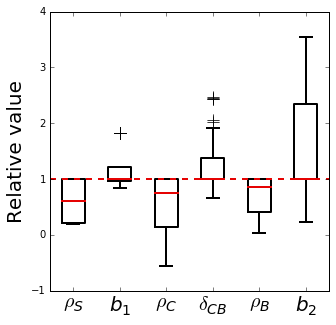

In [9]:
plt.rcParams['figure.figsize']=(5,5)

xticks=(r'$\rho_S$',r'$b_1$',r'$\rho_C$',r'$\delta_{CB}$',r'$\rho_B$',r'$b_2$')

bins=[10,10,10,10,10,10]
width=0.5

bp={'color':'black','linewidth':2}
mp={'color':'#e50303','linewidth':2}
fp={'markersize':12,'color':'black'}

plt.boxplot(Relative_params,widths=width,boxprops=bp,capprops=bp,whiskerprops=bp,medianprops=mp,flierprops=fp)
plt.plot(plt.xlim(),[1,1],'--',linewidth=2,c='#e50303')

plt.xticks(plt.xticks()[0],xticks,fontsize=20)
plt.ylabel('Relative value',fontsize=20)

savefig=False
if savefig:
    plt.savefig('../figures/05_Rapamycin_treatment_model/Rapamycin_all_models_boxplots.pdf',dpi='figure',bbox_inches='tight')

## Model Selection

[61 63 48 29 62 56 57 51 45 60 52 38 50 28 35 31 59 49 44 19 47 55 41 58 27
 11 54 43 30 40 25 34 46 37 33 18 53 21 17 39 26  8 42 10 22 24 15 36 20  6
 12 32  3 16 14  5  9 23  1  7 13  2  4  0]
Model (0, 2, 3, 4, 5)
-2ln(L): 232.3	AIC:    242.3	AICc:   249	Delta:  0	W:      0.9387
Model (0, 1, 2, 3, 4, 5)
-2ln(L): 232	AIC:    244	AICc:   254.5	Delta:  5.54	W:      0.05881
[61, 63]
[[ 0.10188025  0.11060226]
 [ 0.33774221  0.28164247]
 [ 0.24303538  0.24145904]
 [ 0.37609089  0.37547213]
 [ 0.35632384  0.35693276]
 [ 0.03391773  0.03386648]]


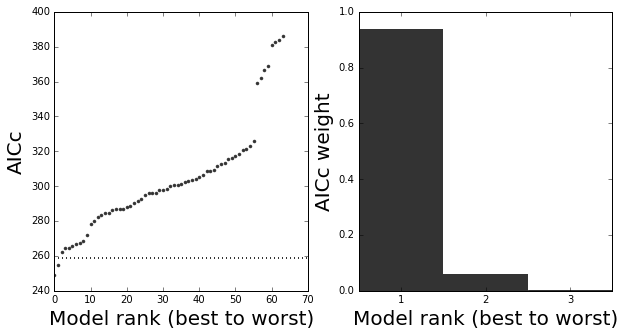

In [10]:
arg=np.argsort(AICcs)
print(arg)
Best_models=[]

plt.rcParams['figure.figsize']=10,5
f,ax=plt.subplots(1,2)

for i in arg:
    if AICcs[i]<=AICcs[arg[0]]+10:
        print('Model',Models[i])
        print('-2ln(L): %.4g\tAIC:    %.4g\tAICc:   %.4g\tDelta:  %.4g\tW:      %.4g'%(Likelihoods[i],AICs[i],AICcs[i],Delta[i],Weights[i]))
    if AICcs[i]<=AICcs[arg[0]]+10:
        Best_models+=[i]
print(Best_models)

Best_Parameters=np.empty((6,len(Best_models)))

for i in range(len(Best_models)):
    model=Models[Best_models[i]]
    Best_Parameters[:,i]=Data[len(model)][model][:-1]

print(Best_Parameters)

for i in range(len(arg)):
    ax[0].plot(i,AICcs[arg[i]],'.',c='0.2')
ax[0].plot(ax[0].get_xlim(),[10+np.min(AICcs),10+np.min(AICcs)],':',linewidth=2,c='0.2',label='min(AICc)+10')
ax[0].set_xlabel('Model rank (best to worst)',fontsize=20)
ax[0].set_ylabel('AICc',fontsize=20)
#plt.legend(loc='upper left',fontsize=20)

imax = np.where(np.cumsum(np.sort(Weights)[::-1]) >= 0.95)[0][0]
ax[1].bar(np.arange(imax+1),np.sort(Weights)[::-1][:(imax+1)],1,facecolor='0.2',edgecolor='None')
ax[1].bar(np.arange(imax+1,2*imax+1),np.sort(Weights)[::-1][imax+1:2*imax+1],1,facecolor='0.2',edgecolor='0.2')
ax[1].set_xlim(0,2*imax+1)
ax[1].set_xticks(0.5+np.arange(3))
ax[1].set_xticklabels(np.arange(1,4))
ax[1].set_xlabel('Model rank (best to worst)',fontsize=20)
ax[1].set_ylabel('AICc weight',fontsize=20)

savefig=False
if savefig:
    plt.savefig('../figures/05_Rapamycin_treatment_model/Rapamycin_AICc_Ranking.pdf',dpi='figure',bbox_inches='tight')

# Parameter variations in the best model

In [11]:
parameters = ('rhoS', 'b1', 'rhoC', 'deltaCB', 'rhoB', 'b2')
index = (0,1,0,1,2,3)

Profiles = []
CI = np.empty((6,2))

for i in range(6):
    data=np.genfromtxt('../data/03_Identifiability_Analysis/%s_%id.profile'%(parameters[i], (duration-1)))
    Profiles+=[{'Parameters':data[:-1],'Profile_Likelihood':data[-1]}]
    CI[i] = PL.Confidence_Interval(Profiles[i], index[i])
    print(CI[i])

Relative_CI = CI / Params_DMSO[:, None]

[ 0.34942793  0.69885585]
[ 0.17731466  1.10610575]
[ 0.04889231  0.7945    ]
[ 0.10955953  0.33780856]
[ 0.43528075  1.26002324]
[ 0.08135695  0.40678477]


/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


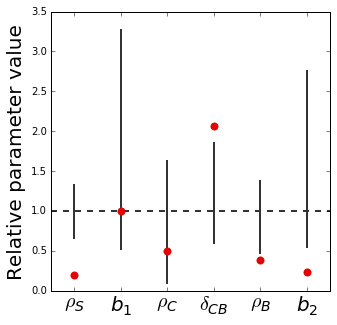

In [13]:
plt.rcParams['figure.figsize']=(5,5)

plt.xlim(-0.5,5.5)
plt.plot(plt.xlim(), (1,1), '--', c='0.2', linewidth=2)

for i in range(6):
    plt.plot([i,i], Relative_CI[i], '-', linewidth=2, c='0.2')
    plt.plot(i, Relative_params[arg[0],i], 'o', markersize=8, c='#e50303', markeredgecolor='None')
    
plt.xticks(np.arange(6),xticks,fontsize=20)
plt.ylabel('Relative parameter value', fontsize=20)

savefig=True
if savefig:
    plt.savefig('../figures/05_Rapamycin_treatment_model/Rapamycin_BestModelRelativeParameters.pdf', dpi='figure', bbox_inches='tight')

# Simulation

0.527438380242 0.337742214473 0.488923074131 0.182599223755 0.916380534664 0.147921736156
0.101880251329 0.337742214473 0.243035378403 0.37609089229 0.356323840241 0.0339177264679


/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rduchesn/Library/Python/3.5/lib/python/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


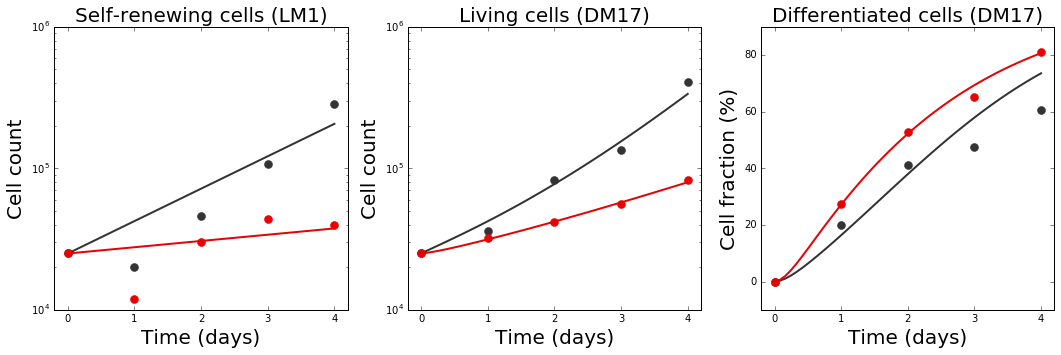

In [14]:
plt.rcParams['figure.figsize']=15,5
f, ax=plt.subplots(1,3)

T=np.linspace(0, duration-1)

Data=np.array([DMSO_data, Rapa_data])
Data[:,2]/=Data[:,1]

Rapa_params=Parameters[:,arg[0]]
Params = np.array((np.concatenate([Params1_DMSO, Params2_DMSO]), Rapa_params))

colors=('0.2','#e50303')

Labels=('Self-renewing cells (LM1)', 'Living cells (DM17)', 'Differentiated cells (DM17)')
Ylabels=('Cell count', 'Cell count', 'Cell fraction (%)')
Treatments=('Untreated','+Rapamycin')

for i in range(2): #treatment
    rhoS, b1, rhoC, deltaCB, rhoB, b2 = Params[i]
    print(rhoS, b1, rhoC, deltaCB, rhoB, b2)
    deltaSC = rhoS + 0.5*np.log(Data[i,0,0])
    S_simul = SCBe.S(T, Data[i,0,0], rhoS)
    TB_simul = SCBe.TB(T, [Data[i,0,0],0,0], rhoS, deltaSC, rhoC, deltaCB, rhoB)
    Simul = np.vstack((S_simul, TB_simul[0], TB_simul[1]/TB_simul[0]))
    
    for j in range(3):
        ax[j].plot(t, Data[i,j],'o',markersize=8,c=colors[i], markeredgecolor=colors[i])
        ax[j].plot(T, Simul[j], linewidth=2, c=colors[i], label=Treatments[i])
        if j <=1:
            ax[j].set_yscale('log')
        ax[j].set_title(Labels[j], fontsize=20)
        ax[j].set_xlabel('Time (days)', fontsize=20)
        ax[j].set_ylabel(Ylabels[j], fontsize=20)
        ax[j].set_xlim((-0.2, duration-0.8))

ax[2].set_yticks(0.2*np.arange(5))
ax[2].set_yticklabels(['0','20','40','60','80'])
#ax[0].legend(loc='upper left',fontsize=20)
plt.tight_layout()

savefig=False
if savefig:
    plt.savefig('../figures/05_Rapamycin_treatment_model/Rapamycin_BestModelSimulation_LogScale.pdf', dpi='figure', bbox_inches='tight')

# Cell distributions

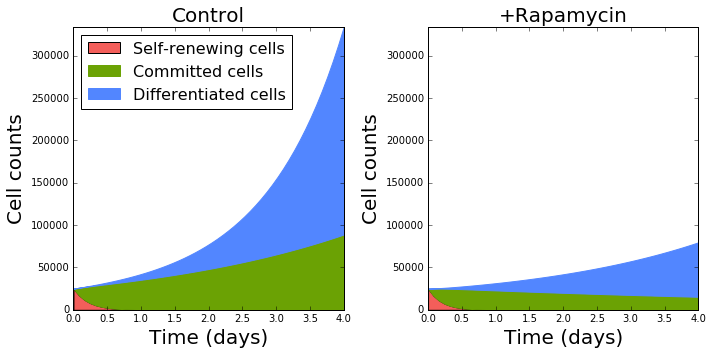

In [16]:
f, ax = plt.subplots(1,2)
plt.rcParams['figure.figsize'] = 10,5

n_time=50
T=np.linspace(0,duration-1,n_time)
SCB=np.empty((2,3,n_time))

cols=['#f35e5a','#6ba204','#5286ff']
treatments=['Control','+Rapamycin']

for i in range(2): #treatment
    rhoS, b1, rhoC, deltaCB, rhoB, b2 = Params[i]
    SCB[i]=SCBe.SCB(T,[Rapa_data[1,0],0,0],rhoS,deltaSC,rhoC,deltaCB,rhoB)
    ax[i].fill_between(T,0,SCB[i,0],facecolor=cols[0],edgecolor=None,label='Self-renewing cells')
    ax[i].fill_between(T,SCB[i,0],np.sum(SCB[i,:2], axis=0),color=cols[1],label='Committed cells')
    ax[i].fill_between(T,np.sum(SCB[i,:2],axis=0),np.sum(SCB[i],axis=0),color=cols[2],label='Differentiated cells')

ymax=np.max(np.sum(SCB, axis=1))
for i in range(2):
    ax[i].set_ylim(0,ymax)
    ax[i].set_xlabel('Time (days)', fontsize=20)
    ax[i].set_ylabel('Cell counts', fontsize=20)
    ax[i].set_title(treatments[i], fontsize=20)

ax[0].legend(loc='upper left', fontsize=16)
plt.tight_layout()

savefig=False
if savefig:
    plt.savefig('../figures/05_Rapamycin_treatment_model/CellDistributions.pdf',dpi='figure',bbox_inches='tight')